# Model 
Here we wish to train and interpret the model using shapley values (TreeSHAP)

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, plot_precision_recall_curve

X = pd.read_csv("trainXAll.csv")
y = pd.read_csv("trainYAll.csv")

Here we define functions to get percentages and non-tracking data into our model

In [27]:
bio_data = pd.read_csv("bio_data.csv")
normal_data = pd.read_csv("summary_data.csv")

def get_height_diff(shooter_id, defender_id):
    defender_height = np.array(bio_data.loc[bio_data['PLAYER_ID'] == (int(defender_id))]['PLAYER_HEIGHT_INCHES'])[0]
    shooter_height = np.array(bio_data.loc[bio_data['PLAYER_ID'] == (int(shooter_id))]['PLAYER_HEIGHT_INCHES'])[0]
    return defender_height-shooter_height

def get_3pt_pct(shooter_id):
    pct = np.array(normal_data.loc[normal_data['PLAYER_ID'] == (int(shooter_id))]['FG3_PCT'])[0]
    return pct

def get_2pt_pct(shooter_id):
    pct = np.array(normal_data.loc[normal_data['PLAYER_ID'] == (int(shooter_id))]['FG_PCT'])[0]
    return pct

def get_name(player_id):
    pct = np.array(normal_data.loc[normal_data['PLAYER_ID'] == (int(player_id))]['PLAYER_NAME'])[0]
    return pct

## Data Wrangling
1) Split our data into train and test sets
2) filter the data to only include 3-pointers from 22-35 feet.

In [28]:
#split train/test dataset
seed = 7
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [29]:
train_x = X_train[['0', '2']].copy()
test_x = X_test[['0', '2']].copy()

In [30]:
train_x['5'] = np.vectorize(get_height_diff)(X_train['3'],X_train['4'])
train_x['6'] = np.vectorize(get_3pt_pct)(X_train['3'])

test_x['5'] = np.vectorize(get_height_diff)(X_test['3'],X_test['4'])
test_x['6'] = np.vectorize(get_3pt_pct)(X_test['3'])

In [31]:
train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)

In [32]:
y_train_filtered = y_train.reset_index(drop=True).loc[(train_x['2'] > 18) & (train_x['2'] < 30)].reset_index(drop=True)
x_train_filtered = train_x.reset_index(drop=True).loc[(train_x['2'] > 18) & (train_x['2'] < 30)].reset_index(drop=True)

In [33]:
y_test_filtered = y_test.reset_index(drop=True).loc[(test_x['2'] > 18) & (test_x['2'] < 30)].reset_index(drop=True)
x_test_filtered = test_x.reset_index(drop=True).loc[(test_x['2'] > 18) & (test_x['2'] < 30)].reset_index(drop=True)

In [34]:
y_train_filtered = y_train_filtered.reset_index(drop=True).loc[(train_x['0'] > 0) & (train_x['0'] < 8)].reset_index(drop=True)
x_train_filtered = x_train_filtered.reset_index(drop=True).loc[(train_x['0'] > 0) & (train_x['0'] < 8)].reset_index(drop=True)

In [35]:
y_test_filtered = y_test_filtered.reset_index(drop=True).loc[(test_x['0'] > 0) & (test_x['0'] < 8)].reset_index(drop=True)
x_test_filtered = x_test_filtered.reset_index(drop=True).loc[(test_x['0'] > 0) & (test_x['0'] < 8)].reset_index(drop=True)

## XGBoost Training
Now we shift into the actual training of the model. 

In [36]:
columns = ['Distance Between Shooter And Defender', 'Shot Distance', 'Difference Between Shooter And Defender Height', '3PT%']

In [37]:
def get_plots_and_metrics(model, y_pred, y_test_filtered=y_test_filtered):
    fpr, tpr, threshold = roc_curve(y_test_filtered, y_pred)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC %s' % str(roc_auc_score(y_test_filtered, y_pred)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    disp = plot_precision_recall_curve(model, x_test_filtered, y_test_filtered)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

[21:59:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { basescore } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




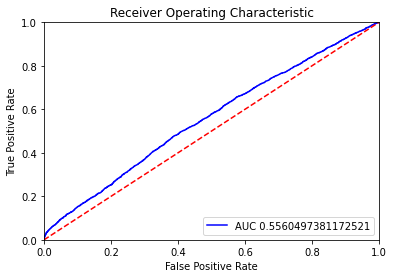

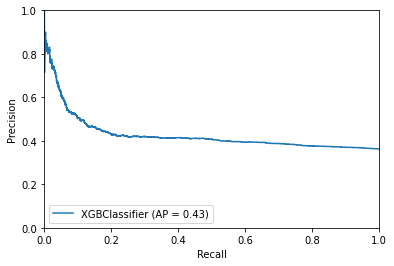

In [38]:
xgboost_model = XGBClassifier(booster='gbtree', 
                              learning_rate=0.05, 
                              max_depth=3, 
                              n_estimators=100, 
                              basescore=0.45, 
                              colsample_bytree=1,
                              subsample=0.8,
                              gamma=0)
xgboost_model.fit(x_train_filtered, y_train_filtered.to_numpy().ravel())
y_pred_xgboost = xgboost_model.predict_proba(x_test_filtered)[:,1]

get_plots_and_metrics(xgboost_model, y_pred_xgboost)
get_plots_and_metrics(xgboost_model, 0.358)

mybooster = xgboost_model.get_booster()

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

In [ ]:
print(log_loss(y_test, model_test_preds))

Text(0.5, 1.0, 'Distribution of Distance From Shooter To Defender')

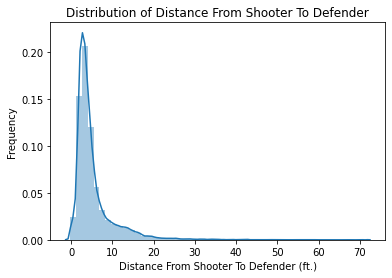

In [82]:
import seaborn as sns
sns.distplot(x_train_filtered['0'])
plt.xlabel("Distance From Shooter To Defender (ft.)")
plt.ylabel("Frequency")
plt.title("Distribution of Distance From Shooter To Defender")

Text(0.5, 1.0, 'Distribution of Distance To Hoop')

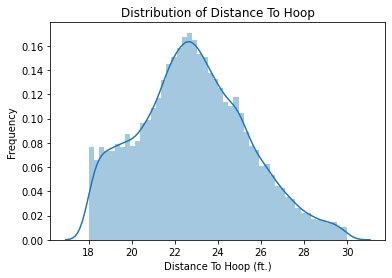

In [83]:
import seaborn as sns
sns.distplot(x_train_filtered['2'])
plt.xlabel("Distance To Hoop (ft.)")
plt.ylabel("Frequency")
plt.title("Distribution of Distance To Hoop")

Text(0.5, 1.0, 'Distribution of Difference in Defender and Shooter Height')

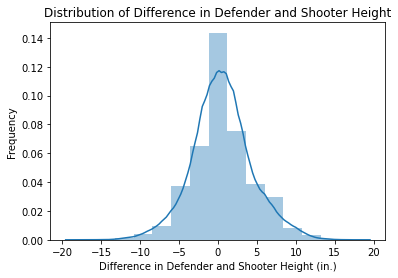

In [94]:
import seaborn as sns
sns.distplot(x_train_filtered['5'], bins=15)
plt.xlabel("Difference in Defender and Shooter Height (in.)")
plt.ylabel("Frequency")
plt.title("Distribution of Difference in Defender and Shooter Height")

Text(0.5, 1.0, 'Distribution of 3PT%')

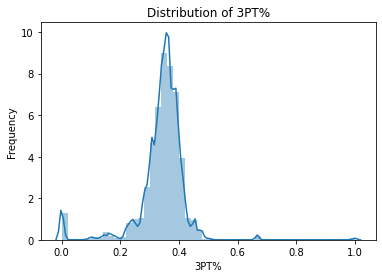

In [95]:
import seaborn as sns
sns.distplot(x_train_filtered['6'])
plt.xlabel("3PT%")
plt.ylabel("Frequency")
plt.title("Distribution of 3PT%")

In [84]:
x_train_filtered.columns

Index(['0', '2', '5', '6'], dtype='object')

In [ ]:
import seaborn as sns
sns.distplot(x_train_filtered['2'])
plt.xlabel("Distance To Hoop (ft.)")
plt.ylabel("Frequency")
plt.title("Distribution of Distance To Hoop")

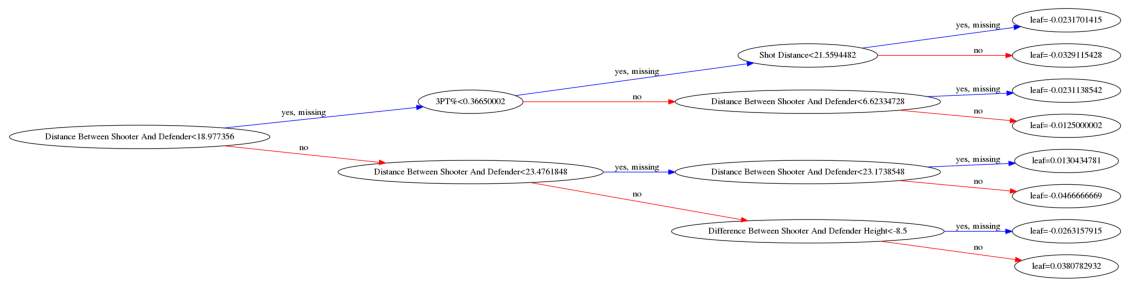

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
plot_tree(xgboost_model, num_trees=0, rankdir='LR', ax=ax)
plt.show()

## XGBoost Interpret
This is the section of code which we care a lot about. 

Using TreeSHAP and in-built XGBoost methods, what are the determinants for shot probability (as learned by the model)?

In [39]:
shap_columns = [a+"IMP" for a in columns]

In [40]:
def get_summary_plot(mybooster, X_test, y_test):
    # Shap explainer initilization
    explainer = shap.TreeExplainer(mybooster)

    shap_values = explainer.shap_values(x_test_filtered)
    shap_df = pd.DataFrame(shap_values, columns=shap_columns)
    shap_df['Y'] = np.array(y_test)
    shap_df['YPred'] = np.array(y_pred_xgboost)
    X_test_df = pd.DataFrame(x_test_filtered, columns=columns)

    result = pd.concat([shap_df, X_test_df], axis=1, sort=False) 
    
    misses = result.loc[result['Y'] == 0]
    makes = result.loc[result['Y'] == 1]

    print("All")
    plt.xlim([0,0.6])
    shap.summary_plot(result[shap_columns].to_numpy(), x_test_filtered, columns, plot_type="bar")
    shap.summary_plot(result[shap_columns].to_numpy(), x_test_filtered, columns)

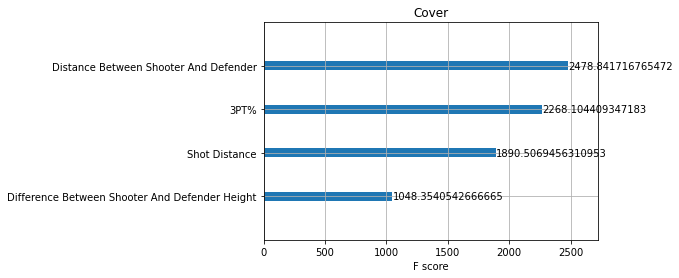

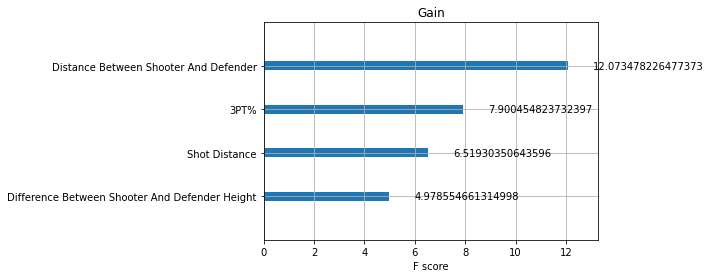

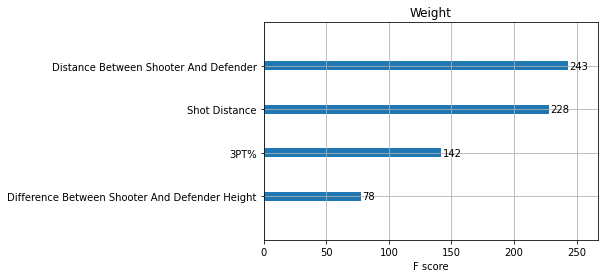

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


All


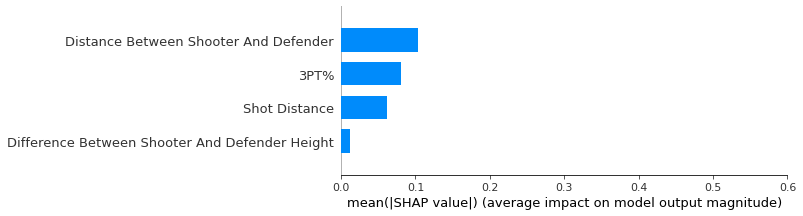

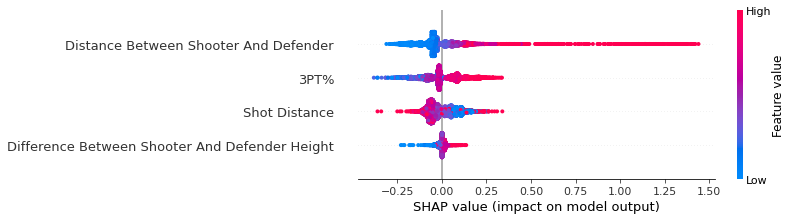

In [41]:
xgboost_model.get_booster().feature_names = columns
xgboost.plot_importance(xgboost_model, importance_type="cover", ylabel=None)
plt.title('Cover')
plt.show()
xgboost.plot_importance(xgboost_model, importance_type="gain", ylabel=None)
plt.title('Gain')
plt.show()
xgboost.plot_importance(xgboost_model, importance_type="weight", ylabel=None)
plt.title('Weight')
plt.show()

# Shap explainer initilization
explainer = shap.TreeExplainer(mybooster)

shap_values = explainer.shap_values(x_test_filtered.reset_index(drop=True))

shap_df = pd.DataFrame(shap_values, columns=shap_columns)
shap_df['Y'] = np.array(y_test_filtered)
shap_df['YPred'] = np.array(y_pred_xgboost)
X_test_df = pd.DataFrame(x_test_filtered, columns=columns)

result = pd.concat([shap_df, X_test_df], axis=1, sort=False) 

misses = result.loc[result['Y'] == 0]
makes = result.loc[result['Y'] == 1]

print("All")
plt.xlim([0,0.6])

shap.summary_plot((result[shap_columns].to_numpy())[0:len(x_test_filtered)], x_test_filtered, columns, plot_type="bar")
shap.summary_plot((result[shap_columns].to_numpy())[0:len(x_test_filtered)], x_test_filtered, columns)